Javier García Serrano, Ana Gil Molina

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 2:  (2 puntos)</strong></div>

Haz uso del cluster para producir modelos de traducción de inglés a francés. Construye un modelo de traducción basado en seq2seq sin atención. Construye otro modelo de traducción  basado en seq2seq con atención según el modelo de Bahdanau. Usa para ambos tamaños de 256 nodos y 1 capa oculta y entrena las redes durante 100 épocas. Compara los resultados. En la resolución del ejercicio incluye la especificación del trabajo SLURM, el script en Python completo para su ejecución en el cluster y el análisis de los resultados.

In [1]:
import os

# Cambiar el directorio
os.chdir("C:/Users/gilpe/Desktop/Máster IA/Primer cuatrimestre/Deep Learning para Procesamiento del Lenguaje Natural/Parte I/Práctica/Datos")
print("Directorio actual:", os.getcwd())

Directorio actual: C:\Users\gilpe\Desktop\Máster IA\Primer cuatrimestre\Deep Learning para Procesamiento del Lenguaje Natural\Parte I\Práctica\Datos


In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preprocesamiento y Almacenamiento de los Datos

Los datos ya se han procesado, y tienen el formato:

English + TAB + French

Cada palabra se representará con un vector one-hot. Se necesitará un único índice para cada palabra, y mediante la clase `Lang` podremos llevar la cuenta de todos en cada lenguaje gracias a los diccionarios `word2index` e `index2word`. Además, para conocer la frecuencia de cada palabra y eliminar aquellas de menor frecuencia, usaremos `word2count`. El número de palabras se almacenará en `n_words`.

In [4]:
SOS_token = 0       # Asignar índice 0 al token SOS inicial
EOS_token = 1       # Asignar índice 1 al token EOS final

class Lang:
    def __init__(self, name):
        self.name = name  # Nombre del idioma
        self.word2index = {}  # Palabra -> índice
        self.word2count = {}  # Palabra -> cantidad de veces que aparece
        self.index2word = {0: "SOS", 1: "EOS"}  # Índice -> palabra
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Como todos los ficheros son unicode, simplificaremos las cosas pasando todo a ASCII, minúsculas, y eliminando todos los signos de puntuación.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

Mediante la función `readLangs` separamos ficheros en líneas, y las líneas en pares. Los ficheros contienen sentencias del inglés a otros lenguajes. Como en nuestro caso vamos a traducir del inglés al francés, debemos dejar `reverse = False`.

In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Filtramos un poco las sentencias para hacerlo más simple y rápido, quedándonos con sentencias de 10 palabras a lo sumo y del tipo  \"I am\", \"He is\", etc. Debemos modificar el código proporcionado en la práctica para que filtre las frases en inglés con los prefijos definidos en `eng_prefixes`, puesto que en el ejemplo de la práctica estas frases se encontraban en `p[1]`, pero ahora se encuentran en `p[0]`, al invertir el orden de los idiomas en la traducción.

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)  # Cambiamos p[1] por p[0]


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Entonces, el proceso global para preparar los datos incluye:

* Leer el fichero de texto, separar en líneas, separar las líneas en pares

* Normalizar el texto, filtrar por longitud y contenido

* Hacer listas de palabras a partir de los pares de sentencias

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [9]:
# Preparar los datos de inglés a francés
input_lang_eng_fra, output_lang_eng_fra, pairs_eng_fra = prepareData('eng', 'fra', False)
print(random.choice(pairs_eng_fra))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
eng 2991
fra 4601
['i m getting a master s degree in education', 'j obtiens un diplome superieur en education']


### Encoder

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### Decoder sin atención

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Decoder basado en atención

In [12]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### Entrenamiento

Modificamos la función `get_dataloader` para que la función `prepareData` tome el parámetro `reverse=Flase`, necesario para que no se invierta el orden de los idiomas, y generar un traductor de inglés a francés.

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', False)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [14]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Una vez definido todo este código, el proceso de entrenamiento consiste en los pasos siguientes

* Lanzamos un temporizador

* Inicializamos los optimizadores y la función de pérdida

* Creamos un conjunto de pares de sentencias para el entrenamiento de la red

* Inicializamos el array de pérdida para el ploteado de su evolución

Tras esto, invocamos a `train` repetidamente y, cada cierto tiempo, imprimimos el progreso del mismo.



In [16]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotear resultados

In [17]:
%matplotlib inline


import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    #plt.show()

### Evaluación

In [18]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

Modificamos la función `evaluateRandomly` para que tome `input_lang`, `output_lang` y `pairs` como parámetro, para poder usarla con los dos modelos:

In [19]:
def evaluateRandomly(encoder, decoder, input_lang, output_lang, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Entrenar red sin atención

El entrenamiento de los modelos se ha realizado en el cluster, y los modelos resultantes ya entrenados se han almacenado en una carpeta *models*.

In [20]:
# Ruta de la carpeta donde guardar los modelos
folder_path = 'models/'

# Verificar si la carpeta existe, si no, crearla
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
eng 2991
fra 4601
3m 37s (- 32m 36s) (10 10%) 1.0694
7m 21s (- 29m 26s) (20 20%) 0.2276
11m 5s (- 25m 52s) (30 30%) 0.1562
14m 48s (- 22m 12s) (40 40%) 0.1432
18m 30s (- 18m 30s) (50 50%) 0.1374
22m 13s (- 14m 48s) (60 60%) 0.1339
25m 55s (- 11m 6s) (70 70%) 0.1310
29m 38s (- 7m 24s) (80 80%) 0.1289
33m 20s (- 3m 42s) (90 90%) 0.1272
400m 17s (- 0m 0s) (100 100%) 0.1258


<Figure size 640x480 with 0 Axes>

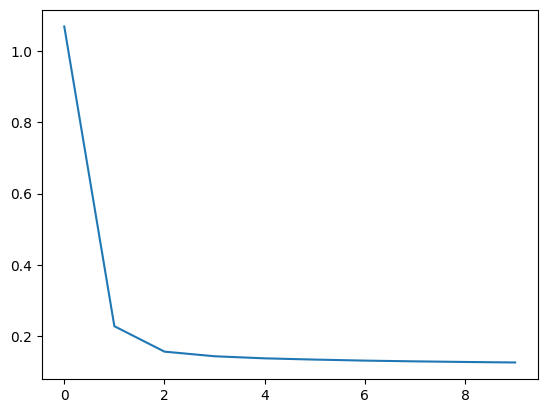

In [22]:
%matplotlib inline

hidden_size = 256
batch_size = 32
n_epochs = 100

# Datos
input_lang_no_attn, output_lang_no_attn, train_dataloader_no_attn = get_dataloader(batch_size)

# Modelos
encoder_no_attn = EncoderRNN(input_lang_no_attn.n_words, hidden_size).to(device)
decoder_no_attn = DecoderRNN(hidden_size, output_lang_no_attn.n_words).to(device)

# Entrenamiento
train(train_dataloader_no_attn, encoder_no_attn, decoder_no_attn, n_epochs, print_every=10, plot_every=10)

# Guardar los modelos dentro de la carpeta
torch.save(encoder_no_attn.state_dict(), os.path.join(folder_path, 'encoder_no_attention.pth'))
torch.save(decoder_no_attn.state_dict(), os.path.join(folder_path, 'decoder_no_attention.pth'))

### Entrenar red con atención

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
eng 2991
fra 4601
4m 24s (- 39m 44s) (10 10%) 0.8567
9m 1s (- 36m 4s) (20 20%) 0.1809
13m 39s (- 31m 51s) (30 30%) 0.1507
18m 22s (- 27m 33s) (40 40%) 0.1421
23m 3s (- 23m 3s) (50 50%) 0.1378
27m 36s (- 18m 24s) (60 60%) 0.1343
32m 26s (- 13m 54s) (70 70%) 0.1326
37m 15s (- 9m 18s) (80 80%) 0.1311
41m 36s (- 4m 37s) (90 90%) 0.1294
46m 9s (- 0m 0s) (100 100%) 0.1288


<Figure size 640x480 with 0 Axes>

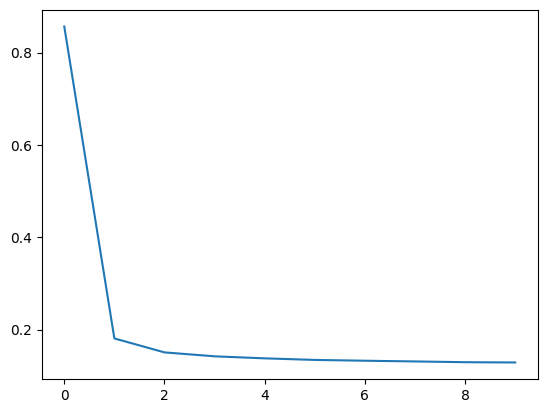

In [23]:
%matplotlib inline

hidden_size = 256
batch_size = 32
n_epochs = 100

# Datos
input_lang_attn, output_lang_attn, train_dataloader_attn = get_dataloader(batch_size)

# Modelos
encoder_attn = EncoderRNN(input_lang_attn.n_words, hidden_size).to(device)
decoder_attn = AttnDecoderRNN(hidden_size, output_lang_attn.n_words).to(device)

# Entrenamiento
train(train_dataloader_attn, encoder_attn, decoder_attn, n_epochs, print_every=10, plot_every=10)

# Guardar los modelos dentro de la carpeta
torch.save(encoder_attn.state_dict(), os.path.join(folder_path, 'encoder_attention.pth'))
torch.save(decoder_attn.state_dict(), os.path.join(folder_path, 'decoder_attention.pth'))

### Cargar modelos

Una vez entrenados los modelos en el cluster, estos se han guardado en la carpeta *models*. Los descargamos del cluster para poder cargarlos en local ya entrenados, y así evaluar su rendimiento.

In [22]:
# Datos
hidden_size = 256
batch_size = 32
input_lang_no_attn, output_lang_no_attn, train_dataloader_no_attn = get_dataloader(batch_size)

# Cargar los modelos sin atención previamente guardados
encoder_no_attn = EncoderRNN(input_lang_no_attn.n_words, hidden_size).to(device)
decoder_no_attn = DecoderRNN(hidden_size, output_lang_no_attn.n_words).to(device)

encoder_no_attn.load_state_dict(torch.load(os.path.join(folder_path, 'encoder_no_attention.pth'), map_location=device))
decoder_no_attn.load_state_dict(torch.load(os.path.join(folder_path, 'decoder_no_attention.pth'), map_location=device))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
eng 2991
fra 4601


C:\Users\gilpe\AppData\Local\Temp\ipykernel_14596\2616207136.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_no_attn.load_state_dict(torch.load(os.path.join(fol

<All keys matched successfully>

In [23]:
# Datos
batch_size = 32
hidden_size = 256
input_lang_attn, output_lang_attn, train_dataloader_attn = get_dataloader(batch_size)

# Cargar los modelos con atención previamente guardados
encoder_attn = EncoderRNN(input_lang_attn.n_words, hidden_size).to(device)
decoder_attn = AttnDecoderRNN(hidden_size, output_lang_attn.n_words).to(device)

encoder_attn.load_state_dict(torch.load(os.path.join(folder_path, 'encoder_attention.pth'), map_location=device))
decoder_attn.load_state_dict(torch.load(os.path.join(folder_path, 'decoder_attention.pth'), map_location=device))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
eng 2991
fra 4601


C:\Users\gilpe\AppData\Local\Temp\ipykernel_14596\398815207.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_attn.load_state_dict(torch.load(os.path.join(folder_

<All keys matched successfully>

### Evaluación

In [21]:
encoder_no_attn.eval()
decoder_no_attn.eval()

# Evaluación del modelo sin atención
evaluateRandomly(encoder_no_attn, decoder_no_attn, input_lang_no_attn, output_lang_no_attn, pairs_eng_fra)

> we re right here
= nous sommes juste la
< nous sommes presque la presque aussi longtemps <EOS>

> she is french
= elle est francaise
< elle est francaise <EOS>

> i m going to hang up now
= je vais maintenant raccrocher
< je vais maintenant raccrocher <EOS>

> she s a determined woman
= c est une femme determinee
< c est une femme d une grande beaute <EOS>

> you re not good at this
= vous n y etes pas bons
< vous n y etes pas bons <EOS>

> i m not writing about you
= je n ecris pas a votre sujet
< je n ecris pas a ton sujet <EOS>

> we re conscientious
= nous sommes consciencieux
< nous sommes consciencieux <EOS>

> he is cranky
= il est excentrique
< il est excentrique de comprendre <EOS>

> i m not asleep
= je ne suis pas endormi
< je ne suis pas endormi pour faire cela <EOS>

> you re finicky
= tu es tatillonne
< vous etes libres de vous en aller en aller <EOS>



In [22]:
encoder_attn.eval()
decoder_attn.eval()

# Evaluación del modelo con atención
evaluateRandomly(encoder_attn, decoder_attn, input_lang_attn, output_lang_attn, pairs_eng_fra)

> he is a rude person
= il est malpoli
< il est malpoli <EOS>

> i m not good with names
= j ai du mal avec les noms
< j ai du mal avec les noms <EOS>

> i m your neighbor
= je suis votre voisin
< je suis votre voisin <EOS>

> i m the same height as he is
= je suis de la meme taille que lui
< je suis de la meme taille que lui <EOS>

> he is what we call a scholar
= il est ce qu on appelle un lettre
< il est ce qu on appelle un lettre <EOS>

> we re fasting
= nous faisons la diete
< nous faisons la diete <EOS>

> i m dying to see you
= je desespere de te voir !
< je desespere de te voir ! <EOS>

> they are exhausted
= elles sont crevees
< elles sont crevees <EOS>

> i m not done with you yet
= je n en ai pas encore fini avec toi
< je n en ai pas encore fini avec toi <EOS>

> he is old enough to understand it
= il est assez age pour le comprendre
< il est assez age pour le comprendre <EOS>



# Testeo de modelos con métricas

Para cada métrica se van a evaluar aleatoriamente 100 frases obtenidas de los archivos de texto.

## Métrica 1: BLEU Score

El BLEU Score es una métrica que evalúa la calidad de las traducciones comparando n-gramas de la traducción generada con la traducción de referencia, midiendo la precisión y penalizando traducciones demasiado largas o cortas mediante un factor de brevedad.

In [37]:
from nltk.translate.bleu_score import sentence_bleu

def evaluateRandomly_BLEU(encoder, decoder, input_lang, output_lang, pairs, n=10):
    total_bleu = 0  # Acumulador para el BLEU promedio

    for i in range(n):
        pair = random.choice(pairs)
        # print('>', pair[0])  # Frase original
        # print('=', pair[1])  # Traducción de referencia

        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words).replace('<EOS>', '').strip()  # Elimina el token EOS

        # print('<', output_sentence)  # Traducción generada

        # Calcular BLEU
        bleu_score = sentence_bleu([pair[1].split()], output_sentence.split())
        total_bleu += bleu_score

        # print(f'BLEU score: {bleu_score:.4f}')  # Mostrar BLEU por oración
        # print('')

    # BLEU promedio para las oraciones evaluadas
    average_bleu = total_bleu / n
    print(f'Average BLEU score over {n} sentences: {average_bleu:.4f}')


In [ ]:
n = 100

# Evaluación del modelo con atención
print('Evaluación del modelo con atención')
evaluateRandomly_BLEU(encoder_attn, decoder_attn, input_lang_attn, output_lang_attn, pairs_eng_fra, n)

# Evaluación del modelo sin atención
print('Evaluación del modelo sin atención')
evaluateRandomly_BLEU(encoder_no_attn, decoder_no_attn, input_lang_no_attn, output_lang_no_attn, pairs_eng_fra, n)
## Métrica 2: METEOR

Evaluación del modelo con atención
Average BLEU score over 100 sentences: 0.5616
Evaluación del modelo sin atención
Average BLEU score over 100 sentences: 0.3563


## Métrica 2: METEOR

La métrica METEOR evalúa la calidad de las traducciones comparando palabras y frases de la salida generada con la frase de referencia, considerando coincidencias exactas, sinónimos, raíces y el orden de las palabras, y priorizando el equilibrio entre precisión y recall.

In [25]:
from nltk.translate.meteor_score import meteor_score

def calculate_meteor(reference, hypothesis):

    # Convertimos las cadenas de texto en listas de palabras
    reference = [reference.split()]
    hypothesis = hypothesis.split()
    
    # Calculamos la métrica METEOR
    score = meteor_score(reference, hypothesis)
    return score

In [31]:
# %pip install nltk

# import nltk
# nltk.download('wordnet')

# Obtenemos la métrica del modelo con atención
def evaluateRandomly_METEOR(encoder, decoder, input_lang, output_lang, pairs, n=10):
    total_meteor = 0  # Acumulador para el METEOR promedio

    for i in range(n):
        pair = random.choice(pairs)
        # print('>', pair[0])  # Frase original
        # print('=', pair[1])  # Traducción de referencia

        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words).replace('<EOS>', '').strip()  # Elimina el token EOS

        # print('<', output_sentence)  # Traducción generada

        # Calcular METEOR
        meteor_score = calculate_meteor(pair[1], output_sentence)
        total_meteor += meteor_score

        # print(f'METEOR score: {meteor_score:.4f}')  # Mostrar METEOR por oración
        # print('')

    # METEOR promedio para las oraciones evaluadas
    average_meteor = total_meteor / n
    print(f'Average METEOR score over {n} sentences: {average_meteor:.4f}')

In [34]:
n=100

# Evaluación del modelo con atención
print('Evaluación del modelo con atención')
evaluateRandomly_METEOR(encoder_attn, decoder_attn, input_lang_attn, output_lang_attn, pairs_eng_fra, n)

# Evaluación del modelo sin atención
print('Evaluación del modelo sin atención')
evaluateRandomly_METEOR(encoder_no_attn, decoder_no_attn, input_lang_no_attn, output_lang_no_attn, pairs_eng_fra, n)

Evaluación del modelo con atención
Average METEOR score over 100 sentences: 0.8396
Evaluación del modelo sin atención
Average METEOR score over 100 sentences: 0.6485


## Métrica 3: ROUGE

Las métricas ROUGE son un conjunto de métricas que se pueden utilizar para evaluar modelos de traducción en procesamiento del lenguaje natural. Dichas métricas comparan una traducción generada automáticamente con una traducción de referencia producida por humanos. Las métricas ROUGE oscilan entre 0 y 1, y las puntuaciones más altas indican una mayor similitud entre la traducción generada por el modelo y la referencia. Algunos ejemplos de estas métricas son:

- ROUGE-1: superposición de unigramas entre la traducción generada por el modelo y la traducción de referencia.
- ROUGE-2: superposición de bigramas entre la traducción generada por el modelo y la traducción de referencia.
- ROUGE-L: estadísticas basadas en la subsecuencia común más larga, que identifica los n-gramas más largos que ocurren simultáneamente en las secuencias.

Usando la librería `rouge_score` podemos calcular estas métricas ROUGE para evaluar nuestros modelos.

Para calcular los promedios de las métricas de ROUGE, modificamos la función `evaluateRandomly` para que en cada ejemplo seleccionado aleatoriamente calcule las métricas ROUGE, y al final calcule el promedio de todos los ejemplos. Nos fijaremos principalmente en la métrica F1, ya que esta muestra un equilibrio entre la precisión y el recall, dado que combina ambas. Esto es importante, ya que:

- Precisión: mide la proporción de palabras en la traducción generada que están en la traducción de referencia.
- Recall: mide la proporción de palabras de la traducción de referencia que están en la traducción generada.

In [43]:
#Métrica 3: ROUGE Score
# %pip install rouge-score
from rouge_score import rouge_scorer

def calculate_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return scores['rougeL'].fmeasure

def evaluateRandomly_ROUGE(encoder, decoder, input_lang, output_lang, pairs, n=10):
    total_rouge = 0  # Acumulador para el ROUGE promedio

    for i in range(n):
        pair = random.choice(pairs)
        # print('>', pair[0])  # Frase original
        # print('=', pair[1])  # Traducción de referencia

        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words).replace('<EOS>', '').strip()  # Elimina el token EOS

        # print('<', output_sentence)  # Traducción generada

        # Calcular ROUGE
        rouge_score = calculate_rouge(pair[1], output_sentence)
        total_rouge += rouge_score

        # print(f'ROUGE score: {rouge_score:.4f}')  # Mostrar ROUGE por oración
        # print('')

    # ROUGE promedio para las oraciones evaluadas
    average_rouge = total_rouge / n
    print(f'Average ROUGE score over {n} sentences: {average_rouge:.4f}')



In [46]:
n = 100

# Evaluación del modelo con atención
print('Evaluación del modelo con atención')
evaluateRandomly_ROUGE(encoder_attn, decoder_attn, input_lang_attn, output_lang_attn, pairs_eng_fra, n)

# Evaluación del modelo sin atención
print('Evaluación del modelo sin atención')
evaluateRandomly_ROUGE(encoder_no_attn, decoder_no_attn, input_lang_no_attn, output_lang_no_attn, pairs_eng_fra, n)

Evaluación del modelo con atención
Average ROUGE score over 100 sentences: 0.8574
Evaluación del modelo sin atención
Average ROUGE score over 100 sentences: 0.6459


## Métrica 4: BERT Score

El BERT score es una métrica usada para evaluar la calidad de un texto generado por un modelo de lenguaje, que se basa en la similitud semántica entre el texto generado y el de referencia, utilizando los embeddings generados por el modelo de BERT. Este modelo proporciona embeddings contextuales a las palabras de una frase, de forma que genera embeddings diferentes para una misma palabra dependiendo de las palabras a su alrededor y del contexto general de la frase. Esto permite al BERT score capturar de manera más efectiva el significado de las palabras dentro de un contexto, incluso si las palabras exactas en el texto generado y el de referencia no coinciden.

In [24]:
from bert_score import score
from transformers import logging
logging.set_verbosity_error()

def calculate_bertscore(output_sentence, reference_sentence):
    P, R, F1 = score([output_sentence], [reference_sentence], lang="en")
    return {"Precision": P.item(), "Recall": R.item(), "F1": F1.item()}

In [25]:
def evaluateRandomly_BERT(encoder, decoder, input_article, output_abstract, pairs, n=10):
    total_precision = 0
    total_recall = 0
    total_f1 = 0

    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])  # Texto original
        print('=', pair[1])  # Traducción real
        output_words, _ = evaluate(encoder, decoder, pair[0], input_article, output_abstract)
        output_sentence = ' '.join(output_words)  # Traducción generada
        print('<', output_sentence)
        print('')

        # Calcular BERT Score
        bert_scores = calculate_bertscore(output_sentence, pair[1])
        precision = bert_scores['Precision']
        recall = bert_scores['Recall']
        f1 = bert_scores['F1']

        total_precision += precision
        total_recall += recall
        total_f1 += f1

        print(f'BERTScore Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
        print('')
    
    # Calcular promedios
    avg_precision = total_precision / n
    avg_recall = total_recall / n
    avg_f1 = total_f1 / n

    print(f'Average BERTScore Precision over {n} sentences: {avg_precision:.4f}')
    print(f'Average BERTScore Recall over {n} sentences: {avg_recall:.4f}')
    print(f'Average BERTScore F1 over {n} sentences: {avg_f1:.4f}')

In [26]:
encoder_no_attn.eval()
decoder_no_attn.eval()

# Evaluación del modelo sin atención
evaluateRandomly_BERT(encoder_no_attn, decoder_no_attn, input_lang_no_attn, output_lang_no_attn, pairs_eng_fra)

> you re out of time
= votre temps est ecoule
< ca fait longtemps qu il est affaire <EOS>

BERTScore Precision: 0.8137, Recall: 0.8193, F1: 0.8165

> she is in low spirits today
= elle n a pas le moral aujourd hui
< elle est en ce meme pauvre <EOS>

BERTScore Precision: 0.8285, Recall: 0.8087, F1: 0.8185

> i am near the station
= je me trouve pres de la gare
< je me trouve pres de la gare de cette affaire

BERTScore Precision: 0.9377, Recall: 0.9675, F1: 0.9524

> you re very emotional
= vous etes tres emotives
< vous etes tres devoir de vouloir y aller <EOS>

BERTScore Precision: 0.8264, Recall: 0.9249, F1: 0.8729

> i am starting this evening
= je commence des ce soir
< je commence a comprendre pourquoi tom aime boston <EOS>

BERTScore Precision: 0.8033, Recall: 0.8647, F1: 0.8329

> i m happy with that
= j en suis contente
< je suis heureux d etre rentre <EOS>

BERTScore Precision: 0.7778, Recall: 0.8085, F1: 0.7929

> we re unprejudiced
= nous sommes depourvues de prejuges
< nous 

In [27]:
encoder_attn.eval()
decoder_attn.eval()

# Evaluación del modelo con atención
evaluateRandomly_BERT(encoder_attn, decoder_attn, input_lang_attn, output_lang_attn, pairs_eng_fra)

> i am very happy in georgia
= je suis tres heureux en georgie
< je suis tres heureux en georgie <EOS>

BERTScore Precision: 0.9320, Recall: 0.9923, F1: 0.9612

> we re all dying
= nous sommes tous en train de mourir
< nous sommes tous en train de mourir <EOS>

BERTScore Precision: 0.9400, Recall: 0.9940, F1: 0.9663

> i m sick and tired of reading
= je suis fatigue de lire
< je suis fatigue de lire <EOS>

BERTScore Precision: 0.9025, Recall: 0.9870, F1: 0.9429

> you are early
= vous etes en avance
< tu es matinal <EOS>

BERTScore Precision: 0.8097, Recall: 0.7966, F1: 0.8031

> he s smart
= il est intelligent
< il est intelligent <EOS>

BERTScore Precision: 0.8416, Recall: 0.9469, F1: 0.8912

> you are not supposed to smoke here
= tu n es pas cense fumer ici
< vous n etes pas censee fumer ici <EOS>

BERTScore Precision: 0.8214, Recall: 0.8740, F1: 0.8469

> she is the one who feeds our dog
= c est elle qui nourrit notre chien
< c est elle qui nourrit notre chien <EOS>

BERTScore Prec

## Conclusión

Con todas las métricas, hemos observado como el modelo con atención obtiene resultados considerablemente mejores que el modelo sin atención. Esto sugiere que el mecanismo de atención mejora las capacidades del modelo para capturar las relaciones contextuales entre palabras y frases. Al asignar diferentes pesos a las partes relevantes de la frase durante la generación de la traducción, se logra una representación mucho más precisa y se logra captar mejor el contexto y el significado de la frase.